# Raster Fundamentals: GDAL, rasterio, Landsat-8

UW Geospatial Data Analysis  
CEE498/CEWA599  
David Shean  

## Objectives
* Learn how to inspect, read and write raster data
* Understand raster transforms, window/extent operations, contrast enhancement, and interpolation
* Perform basic raster band math operations using NumPy, compute NDVI/NDSI
* Perform quantitative raster analysis with thresholds and binary masks
* Understand programmtic Landsat-8 archive access and download

## Tools
* GDAL
* Rasterio
* NumPy

# Introduction

## What is a raster?

## Raster data sources
* Satellite imagery
* Gridded model output
* Interpolated vector data

# Raster fundamentals (interactive discussion)

### Dimensions (width [columns] and height [rows] in pixels)
### CRS (coordinate system)
### Extent (bounds)
### Resolution (pixel size)
### Data type (bit depth)
### Number of bands
### NoData values
    * NumPy masked arrays vs. float/np.nan  
### Overviews

## GDAL (Geospatial Data Abstraction Library) and Rasterio
GDAL is a powerful and mature library for reading, writing and warping raster datasets, written in C++ with bindings to other languages. There are a variety of geospatial libraries available on the python package index, and almost all of them depend on GDAL. One such python library developed and supported by Mapbox, rasterio, builds on top of GDAL’s many features, but provides a more pythonic interface and supports many of the features and formats that GDAL supports. Both GDAL and rasterio are constantly being updated and improved.

## Raster formats
* GeoTiff is most common
* GDAL is the foundation

## Projections
* Most often UTM
* PROJ is the foundation

## Raster transformations
* Need a way to go from pixel coordinates (image on your screen) to real-world coordinates (projected)
    * Pixel coordinates: image width, height in units of pixels, starting at (0,0)
    * Real-world coordiantes: projected coordinate system (e.g., UTM 10N), units of meters
* Origin is usually upper left corner of upper left pixel
    * Careful about this - you will definitely run into this problem at some point
    * Often your grid may be shifted by a half a pixel in x and y

### GDAL/ESRI affine

### rasterio affine

## GDAL command line utilities

* Learn these: https://gdal.org/programs/index.html
    * gdalinfo
    * gdal_translate
    * gdalwarp
    * gdaladdo
* Items to discuss
    * Use standard creation options (co)
        * TILED=YES
        * COMPRESS=LZW
        * BIGTIFF=IF_SAFER
    * Resampling algorithms
        * Default is nearest
        * Often bilinear or bicubic is a better choice for reprojecting, upsampling, downsampling

https://medium.com/planet-stories/a-gentle-introduction-to-gdal-part-4-working-with-satellite-data-d3835b5e2971

# Landsat
* Hopefully you've all seen or used Landsat imagery at some point in the past
* Take a few minutes to refresh your memory: https://www.usgs.gov/land-resources/nli/landsat
* There is a huge amount of information out there on the Landsat missions, data products, science results

## Landsat-8
* Landsat-8 is the mission (a satellite)
    * Operatioinial Land Imager (OLI) is an instrument (a camera)
    * Thermal Infrared Sensor (TIRS) is an insitrument (also a camera)

https://www.usgs.gov/land-resources/nli/landsat/landsat-8

## Bands
* https://landsat.usgs.gov/what-are-band-designations-landsat-satellites

![LS8 band table](https://prd-wret.s3-us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/styles/full_width/public/thumbnails/image/Landsat%208%20band%20designations.jpg)

So, Landsat-8 sensor is the top row of colored bands in the following figure (lower rows are for older Landsat sensors):

![LS8 bands](https://landsat.usgs.gov/sites/default/files/images/MSS-thru-L9-wavelengths.jpg)

## Landsat-8 Data Products

These are "Level 1" images: they radiometrically corrected and orthorectified (terrain corrected) in UTM projection: https://landsat.usgs.gov/landsat-level-1-standard-data-products

For more sophisticated analysis, you typically want to use higher-level, calibrated/corrected products ("level 2" like surface reflectance values): https://www.usgs.gov/land-resources/nli/landsat/landsat-science-products

### Dynamic Range
* LS8 OLI provides 12-bit dynamic range: https://landsat.usgs.gov/how-does-landsat-8s-12-bit-data-improve-data-products
    * Remember, each bit is a 0 or 1.  We have 12 of them, so we have 2^12 (or 4096) unique combinations to represent brightness in the image.
* Most data types on a computer are in multiples of 8-bit bytes.  For example, a typical image of a cat face contains three 8-bit channels for red, green and blue values
* We don't have a convenient mechanism to store 12-bit data, so the LS8 images are stored as 16-bit unsigned integers (2^16 possible values, 0-65535)

### Image Resolution - Ground Sample Distance (GSD)
* PAN band (8) is 15 m ground sample distance (GSD)
* Multispectral (MS) bands are 30 m GSD
* Thermal IR are 100 m GSD

* LS imagery is already orthorectified
    * Original "Level 0" or "Level 1A" imagery in sensor coordinates is not available
    * Most people want orthoimages
    * Can be distortion if the DEM used for orthorectification contains errors (or the surface has changed between the DEM timestamp and image timestamp)

### Revisit interval of 16 days

### Path/Row system
* https://landsat.gsfc.nasa.gov/the-worldwide-reference-system/
* Use descending for daytime imagery
* Seattle and Mt. Rainier: path 46, row 27

### LS8 Data availability

USGS/NASA hosts the official Landsat products:
* https://earthexplorer.usgs.gov/

This is clunky and requires a lot of manual steps. Both Google and Amazon mirror the entire USGS archive, and provide a much more efficient API (application programming interface) to access the data.  This is especially important when you need to access 100s-1000s of images.

Google:
* https://cloud.google.com/storage/docs/public-datasets/landsat

Amazon Web Services (AWS): 
* https://docs.opendata.aws/landsat-pds/readme.html
* https://registry.opendata.aws/landsat-8/

In [1]:
import os
import urllib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from osgeo import gdal
import rasterio as rio
import rasterio.plot

In [3]:
#Useful package to add dynamic scalebar to matplotlib images
from matplotlib_scalebar.scalebar import ScaleBar

In [4]:
#We want to use interactive plotting for zoom/pan and live coordinate display
#%matplotlib widget
%matplotlib inline

## Finding cloud-free imagery
* Can use EarthExplorer for visual queries: https://earthexplorer.usgs.gov/
    * Get the image ID
    * Can also directly download products from EarthExplorer, but pretty inefficient
* There are automated ways to query the archives from Python or command-line, but for now, let's just use pre-identified images or manually identified IDs

In [5]:
#img_id = 'LC08_L1TP_042034_20170616_20170629_01_T1'
#image_url = 'https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/LC08_L1TP_042034_20170616_20170629_01_T1_B3.TIF'

## Let's download some sample imagery for faster analysis (though we could access dynamically)
* Note that transfer rates from Google Cloud should be excellent, as we're running this Jupyterhub on a Google Cloud Platform (GCP) server
* Notes about LS filenames: https://gisgeography.com/landsat-file-naming-convention/

In [6]:
#Use Google Cloud archive
base_url = 'https://storage.googleapis.com/gcp-public-data-landsat/LC08/01'

#Define Landsat path/row for Western Washington
path = 46
row = 27

#Pre-identified cloud-free Image IDs for this path/row 
#Winter 2018
img_id1 = 'LC08_L1TP_046027_20181224_20190129_01_T1'
#Summer 2018
img_id2 = 'LC08_L1TP_046027_20180818_20180829_01_T1'

In [7]:
#Create local directory to store images
imgdir = 'LS8_sample'
if not os.path.exists(imgdir):
    os.makedirs(imgdir)

#Loop through all selected images and all bands
for img in (img_id1, img_id2):
    for b in range(1,12):
        #Generate the appropriate URL for the images we identified
        image_url =  '{0}/{1:03d}/{2:03d}/{3}/{3}_B{4}.TIF'.format(base_url, path, row, img, b)
        print(image_url)
        #Local filename
        out_fn = os.path.join(imgdir, os.path.split(image_url)[-1])
        #Check to see if file already exists
        if not os.path.exists(out_fn):
            print("Saving:", out_fn)
            #Download the file
            urllib.request.urlretrieve(image_url, out_fn)

https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/046/027/LC08_L1TP_046027_20181224_20190129_01_T1/LC08_L1TP_046027_20181224_20190129_01_T1_B1.TIF
https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/046/027/LC08_L1TP_046027_20181224_20190129_01_T1/LC08_L1TP_046027_20181224_20190129_01_T1_B2.TIF
https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/046/027/LC08_L1TP_046027_20181224_20190129_01_T1/LC08_L1TP_046027_20181224_20190129_01_T1_B3.TIF
https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/046/027/LC08_L1TP_046027_20181224_20190129_01_T1/LC08_L1TP_046027_20181224_20190129_01_T1_B4.TIF
https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/046/027/LC08_L1TP_046027_20181224_20190129_01_T1/LC08_L1TP_046027_20181224_20190129_01_T1_B5.TIF
https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/046/027/LC08_L1TP_046027_20181224_20190129_01_T1/LC08_L1TP_046027_20181224_20190129_01_T1_B6.TIF
https://storage.googleapis.com/gcp-publi

## Do a quick `ls -lh` on the local image directory
* Note relative file sizes for the different bands
    * B8 vs B3 vs. B10
    * Revisit the chart above - does this make sense for resolution of these bands?

In [8]:
!ls -lh LS8_sample

total 1.8G
-rw-r--r-- 1 jovyan users  61M May 26 06:52 LC08_L1TP_046027_20180818_20180829_01_T1_B10.TIF
-rw-r--r-- 1 jovyan users  58M May 26 06:52 LC08_L1TP_046027_20180818_20180829_01_T1_B11.TIF
-rw-r--r-- 1 jovyan users  59M May 26 06:51 LC08_L1TP_046027_20180818_20180829_01_T1_B1.TIF
-rw-r--r-- 1 jovyan users  60M May 26 06:51 LC08_L1TP_046027_20180818_20180829_01_T1_B2.TIF
-rw-r--r-- 1 jovyan users  64M May 26 06:51 LC08_L1TP_046027_20180818_20180829_01_T1_B3.TIF
-rw-r--r-- 1 jovyan users  67M May 26 06:51 LC08_L1TP_046027_20180818_20180829_01_T1_B4.TIF
-rw-r--r-- 1 jovyan users  85M May 26 06:51 LC08_L1TP_046027_20180818_20180829_01_T1_B5.TIF
-rw-r--r-- 1 jovyan users  85M May 26 06:52 LC08_L1TP_046027_20180818_20180829_01_T1_B6.TIF
-rw-r--r-- 1 jovyan users  79M May 26 06:52 LC08_L1TP_046027_20180818_20180829_01_T1_B7.TIF
-rw-r--r-- 1 jovyan users 257M May 26 06:52 LC08_L1TP_046027_20180818_20180829_01_T1_B8.TIF
-rw-r--r-- 1 jovyan users  43M May 26 06:52 LC08_L1TP_046027_201808

## Use `gdalinfo` command to get some basic information about one of the files
* Review each line of the output with your neighbor/group
    * Talk about what each line means, if there is something you don't understand, ask!  Or look it up together!

In [9]:
sample_fn = os.path.join(imgdir, img+'_B1.TIF')
print(sample_fn)

LS8_sample/LC08_L1TP_046027_20180818_20180829_01_T1_B1.TIF


In [10]:
!gdalinfo $sample_fn

Driver: GTiff/GeoTIFF
Files: LS8_sample/LC08_L1TP_046027_20180818_20180829_01_T1_B1.TIF
Size is 7781, 7881
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 10N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 10N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-123,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["metre",1

## Specify filenames for specific bands used for later examples

In [11]:
#Specify filenames for different bands we will need for the lab
#Check table from background section to see wavelengths of each band number
r_fn = os.path.join(imgdir, img+'_B4.TIF')
g_fn = os.path.join(imgdir, img+'_B3.TIF')
b_fn = os.path.join(imgdir, img+'_B2.TIF')
nir_fn = os.path.join(imgdir, img+'_B5.TIF')
swir_fn = os.path.join(imgdir, img+'_B6.TIF')
p_fn = os.path.join(imgdir, img+'_B8.TIF')

# GDAL Python API basics
* I'm including this for reference
    * It's not that complicated, even though rasterio is the more popular option for Python these days (partly because of much better documentation)
* https://gdal.org/user/raster_data_model.html
* https://github.com/OSGeo/gdal/tree/master/gdal/swig/python/samples
* https://pcjericks.github.io/py-gdalogr-cookbook/index.html

In [12]:
#Open tif file as GDAL Dataset object
ds = gdal.Open(g_fn)

In [13]:
#Get the raster band
gdal_b = ds.GetRasterBand(1)
#Read into array
a = gdal_b.ReadAsArray()

In [14]:
#Inspect the array
a

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

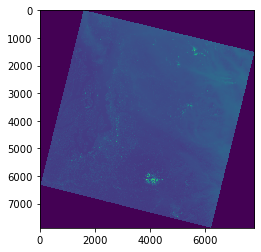

In [15]:
#View the array
f, ax = plt.subplots()
ax.imshow(a);

In [16]:
#Set array to None (frees up RAM) and close GDAL dataset
a = None
ds = None

# Rasterio basics
* We'll stick with rasterio for most of our Python raster analysis 
* https://rasterio.readthedocs.io/en/stable/quickstart.html

## Open an image directly from a url (look Ma, no downloads!)

In [17]:
print(image_url)

https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/046/027/LC08_L1TP_046027_20180818_20180829_01_T1/LC08_L1TP_046027_20180818_20180829_01_T1_B11.TIF


## Use a python `with` construct to cleanly open, inspect, and close the file directly from the url
* Print out the rasterio dataset profile
* We will temporarily store the rasterio dataset with variable name `src` (short for "source")

In [18]:
with rio.open(image_url) as src:
    print(src.profile)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7781, 'height': 7881, 'count': 1, 'crs': CRS.from_epsg(32610), 'transform': Affine(30.0, 0.0, 473385.0,
       0.0, -30.0, 5373315.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


In [19]:
#Note that the dataset does not remain open!
src

<closed DatasetReader name='https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/046/027/LC08_L1TP_046027_20180818_20180829_01_T1/LC08_L1TP_046027_20180818_20180829_01_T1_B11.TIF' mode='r'>

## Can also open dataset from url with rasterio for persistence and interactive access
* Remember to close the rasterio dataset later

In [20]:
src = rio.open(image_url)

In [21]:
src

<open DatasetReader name='https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/046/027/LC08_L1TP_046027_20180818_20180829_01_T1/LC08_L1TP_046027_20180818_20180829_01_T1_B11.TIF' mode='r'>

In [22]:
src.profile

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7781, 'height': 7881, 'count': 1, 'crs': CRS.from_epsg(32610), 'transform': Affine(30.0, 0.0, 473385.0,
       0.0, -30.0, 5373315.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

In [23]:
a = src.read(1)

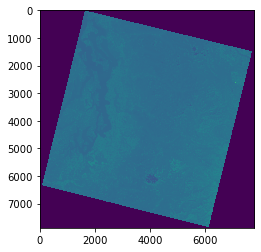

In [24]:
f,ax = plt.subplots()
ax.imshow(a);

In [25]:
src.close()

## Open a single image from disk
* Since we already downloaded these images locally, let's open the local copy of the red band (B4) TIF file
* We already defined the r_fn available above

In [26]:
print(r_fn)
src = rio.open(r_fn)

LS8_sample/LC08_L1TP_046027_20180818_20180829_01_T1_B4.TIF


## What is the CRS?
* Look familiar?  The underlying `fiona` functionality (used by `geopandas`) was written by the same author. 
* Take a minute to look up this EPSG code
* **Add a cell and copy the proj string for this projection**

In [27]:
src.crs

CRS.from_epsg(32610)

## What is the raster extent (bounds) in projected coordinates?
* Note that this is not a simple python `list` object, but a special `BoundingBox` object with attributes for `left`, `bottom`, etc.
    * The logic here is that there are multiple ways to store the order of values that correspond to min_x, min_y, max_x, max_y

In [28]:
src.bounds

BoundingBox(left=473385.0, bottom=5136885.0, right=706815.0, top=5373315.0)

In [29]:
#Isolate the left bound
src.bounds.left

473385.0

## User rasterio to determine the number bands in this tif file

In [30]:
src.count

1

## Review the profile and metadata record
* Use the rasterio `profile` and `meta` attribute, which should return dictionaries

In [31]:
src.profile

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7781, 'height': 7881, 'count': 1, 'crs': CRS.from_epsg(32610), 'transform': Affine(30.0, 0.0, 473385.0,
       0.0, -30.0, 5373315.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

In [32]:
src.meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': None,
 'width': 7781,
 'height': 7881,
 'count': 1,
 'crs': CRS.from_epsg(32610),
 'transform': Affine(30.0, 0.0, 473385.0,
        0.0, -30.0, 5373315.0)}

## Read the data into a NumPy array and preview
* What band number do you need to use here? 
    * Remember, that this is Landsat band 4 (multispectral image band)
    * But each band is stored as a separate TIF file (see the band `count` attribute in the profile)
    * So using rasterio `read`, which band do you need to load?

## What are the dimensions of the NumPy array?  
* Is this consistent with the rasterio dataset `width` and `height` attributes?
* Use this as a reminder about the ordering of NumPy indices (row, col) is (y,x)

## What is the uncompressed filesize of this array in megabytes?
* You'll need to consider the data type and dimensions
* This is how much RAM the image is occupying on your system
* How does this compare with the file size of the TIF file on disk (from earlier `ls -alh`)?
    * If different, why might they be different?

## Create a plot of the image
* Use matplotlib `imshow`
* Use the `gray` color ramp
* If using `%matplotlib widget` backend, I recommend you start with `f,ax = plt.subplots()`, which will create a new figure in the cell (otherwise, your `imshow` output could end up in an earlier figure).

* Note that the image appears "rotated" relative to the frame
    * **Why is this?**
* Note the array coordinate system (where is the (0,0) origin)
* Interactively look at coordinates and pixel values (digital number [DN]) as you move your mouse over the image
    * The DN is the pixel value from the sensor, but not a calibrated surface reflectance value (which would have dimensionless values over the range 0.0-1.0)
    * Check DN values over Mt. Rainier, Puget Sound, and the outer "black" border

Rotation is related to a few factors:
* Landsat-8 is in sun-synchronous orbit (https://en.wikipedia.org/wiki/Sun-synchronous_orbit), meaning that it's always the same time of day beneath the spacecraft for images in each path/row. To accomplish this, the orbital inclination of Landsat-8 is 98.2°, meaning it doesn't go directly over the north and south pole, but is "tilted" relative to lines of longitude.
* In addition, our UTM 10N projection further transforms the valid data, adding to this "rotated" appearance

## Create a histogram plot of DN (digital number) values in your array
* Does `hist()` expect a 2D array or a 1D array? Maybe consider the NumPy `ravel` function...
* Make sure you use enough bins!  Try at least ~200.
* Which bin has the highest count of pixels?
* Over what range do most of the DN values fall?
    * Is this consistent with the 16-bit integer datatype (should have 2^16 possible values)?

## Let's get rid of that black (DN values equal 0) border
* Note that the images as stored on Google Cloud do not have a `nodata` value set
* So when we load into NumPy array, the 0 values around the margins are consider valid pixels
* Two options:
    1. Set values of 0 to `np.nan`
        * Note that `np.nan` is a special `float` object, so we will need to convert our array to using `astype(float)`
            * This means we unnecessarily double or quadruple the amount of RAM required to store these values, as `float32` occupies 4 bytes, and the default NumPy `float` is actually `float64` or 8 bytes!  This can be a real issue for large arrays. For this reason, I typically prefer masked arrays.
        * Note that there are a growing number of "nan-aware" functions in NumPy (e.g., np.nanpercentile), but the options are still limited
    2. Use a NumPy masked array (should be simple one-liner)
        * Take a few minutes to read about masked arrays
            * https://docs.scipy.org/doc/numpy/reference/maskedarray.generic.html#what-is-a-masked-array
            * https://docs.scipy.org/doc/numpy/reference/maskedarray.generic.html
            * Masked arrays allow for masking invalid values (e.g., `nodata`) on any datatype (like `UInt16`)
                * Stores the mask as an additoinal 1-bit boolean array
        * See the `masked_equal` function to create a masked array from an existing array 
    * More info on rasterio nodata and mask support: https://rasterio.readthedocs.io/en/latest/topics/masks.html
* Preview your new array, inspect the mask
* Try plotting with imshow with `gray` cmap

In [47]:
#Example using np.nan
r_masked = r.astype(float)
r_masked[r_masked==0] = np.nan
#Preview every 1000th pixel
r_masked[::1000,::1000]

array([[   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan],
       [   nan,    nan,  8128.,  9418.,  9428.,  9787.,    nan,    nan],
       [   nan,    nan,  7322.,  9244.,  8337., 14929., 11055., 11112.],
       [   nan,  6588.,  7456.,  8275.,  8369.,  8443.,  9229., 11052.],
       [   nan,  6974.,  7554.,  9271.,  7805.,  8191.,  9352., 10667.],
       [   nan,  6377., 10667.,  8681.,  6885.,  7360.,  8598.,    nan],
       [   nan,  6792.,  8777.,  8000., 12859.,  7189., 10059.,    nan],
       [   nan,    nan,    nan,  6339.,  6545.,  7362.,  7770.,    nan]])

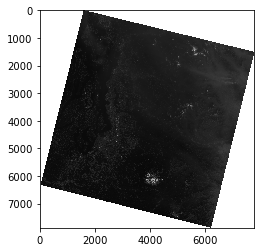

In [48]:
f, ax = plt.subplots()
ax.imshow(r_masked, cmap='gray');

In [49]:
#Example using masked array
#np.ma.array constructor
#r_masked = np.ma.array(r, mask=(r==0))
#masked_equal convenience function
r_masked = np.ma.masked_equal(r, 0)
#Preview every 1000th pixel
r_masked[::1000,::1000]

masked_array(
  data=[[--, --, --, --, --, --, --, --],
        [--, --, 8128, 9418, 9428, 9787, --, --],
        [--, --, 7322, 9244, 8337, 14929, 11055, 11112],
        [--, 6588, 7456, 8275, 8369, 8443, 9229, 11052],
        [--, 6974, 7554, 9271, 7805, 8191, 9352, 10667],
        [--, 6377, 10667, 8681, 6885, 7360, 8598, --],
        [--, 6792, 8777, 8000, 12859, 7189, 10059, --],
        [--, --, --, 6339, 6545, 7362, 7770, --]],
  mask=[[ True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True, False, False, False, False,  True,  True],
        [ True,  True, False, False, False, False, False, False],
        [ True, False, False, False, False, False, False, False],
        [ True, False, False, False, False, False, False, False],
        [ True, False, False, False, False, False, False,  True],
        [ True, False, False, False, False, False, False,  True],
        [ True,  True,  True, False, False, False, False,  True]],
  fill_value=0,
  dtype=uint16)

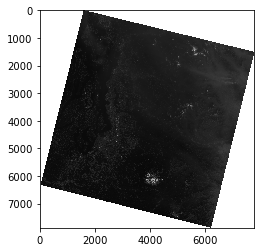

In [50]:
f, ax = plt.subplots()
ax.imshow(r_masked, cmap='gray');

## Replot the histogram of your masked array
* Remember to covert your 2D masked array to 1D before running `hist()`
* There should no longer be a spike for the 0 bin

## Determine the pixel DN (digital number) representing the 2nd and 98th percentile
* Note that if you're using a masked array, you will need to get only unmasked values by running `compressed()` on your masked array, then passing to the `np.percentile` function
* Plot these as vertical dotted black lines on your histogram
    * Hopefully this helps visualize what these percentile values represent based on your distribution.

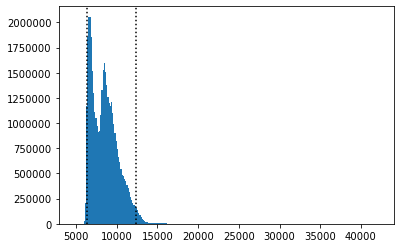

# Raster transform
* Inspect the rasterio `transform`
* Review this: https://rasterio.readthedocs.io/en/stable/topics/georeferencing.html?highlight=affine#coordinate-transformation

In [55]:
src.transform

Affine(30.0, 0.0, 473385.0,
       0.0, -30.0, 5373315.0)

## In your own words, what does this thing do?  

## Use the transform to calculate the projected coordinates of the array corners
* Use the rasterio dataset `bounds` attribute to get the "truth" (you already did this)
* Creating tuples of array corner pixel coordinates (e.g. [(0,0), (array.shape[0],0), ...]
    * Useful to think of corners as upper left, lower left, upper right, lower right
    * Careful about mixing (rows, columns) and (x, y)
    * I recommend you draw a quick sketch here
* Use the affine transformation to convert to projected coordinates
* What are the total dimensions of the projected image in km?
    * Sanity check! Remember your approximate LS-8 image footprint dimensions in km - make sure your calculated values are somewhat consistent!

In [56]:
src.bounds

BoundingBox(left=473385.0, bottom=5136885.0, right=706815.0, top=5373315.0)

In [57]:
src.transform

Affine(30.0, 0.0, 473385.0,
       0.0, -30.0, 5373315.0)

In [58]:
r_masked.shape

(7881, 7781)

In [59]:
#These are (x,y) for corners in pixel space
#A bit confusing due to (row,col) of shape, which is (y,x)

#Upper left
ul = (0, 0)
#Lower left
ll = (0, r_masked.shape[0])
#Upper right

#Lower right


In [ ]:
#Transform upper left corner
ul_proj = src.transform * ul
ul_proj

## Determine the array indices (row, column) of the center pixel
* Try to use array attributes (like `shape`) here, instead of hardcoding values
* Note that we have an odd number of rows and columns in this array, so the actual center indices may not be integers!

## Determine the DN value at this center pixel using array indexing
* Don't overthink this, just extract a value from the numpy array for the (row, col) indices you determined
* Make sure you are using integer values here (may need to convert/round), or NumPy will return an `IndexError`

## Determine the projected coordinates of the center pixel
* Review the rasterio `xy` method: https://rasterio.readthedocs.io/en/stable/api/rasterio.transform.html
    * Careful about x and y coordinate order when using your row and column indices
* Sanity check your projected coordinates with rasterio `index` method - this should return your (row, col) indices
* These two functions allow you to go back and forth between the image/array coordiantes and the projected coordinate system!

## Extra Credit: sample the rasterio dataset at these projected coordinates
* See https://rasterio.readthedocs.io/en/latest/api/rasterio.sample.html
* Note that this will return an iterable generator, so will need to evaluate (can use `list()` operator)
* The resulting DN value should be similar to the value you extracted directly from the array

## Now, apply what you've learned! Get the DN value at the following projected coordinates
* (522785.0, 5323315.0)
* (`src.bounds.left + 50000`, `src.bounds.top - 50000`)
* See https://rasterio.readthedocs.io/en/latest/api/rasterio.transform.html#rasterio.transform.TransformMethodsMixin.index

## Define the full-image `extent` in projected coordinates to pass to matplotlib imshow
* See doc on `extent` here: https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.imshow.html
* Note that the matplotlib `extent` is similar to the rasterio `bounds`, but not identical!
    * Be careful about ordering of (left, bottom, right, top) vs. (min_x, max_x, min_y, max_y)!
    * There is also a convenience function to get the matplotlib `extent` for a rasterio Dataset: https://rasterio.readthedocs.io/en/latest/api/rasterio.plot.html#rasterio.plot.plotting_extent

In [34]:
#This is rasterio bounds
src.bounds

BoundingBox(left=473385.0, bottom=5136885.0, right=706815.0, top=5373315.0)

In [35]:
#This is matplotlib extent
extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
print(extent)

[473385.0, 706815.0, 5136885.0, 5373315.0]


In [36]:
#rasterio convenience function
extent = rio.plot.plotting_extent(src)
print(extent)

(473385.0, 706815.0, 5136885.0, 5373315.0)


## Plot the full image with `imshow`, but now pass this `extent` as an argument
* Note how the axes coordinates change
    * These should now be meters in the UTM 10N coordinate system of the projected image!

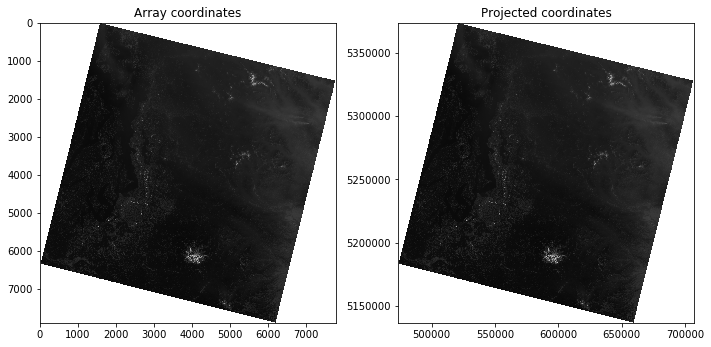

## Add a dynamic scalebar to the above plot
* See documentation: https://pypi.org/project/matplotlib-scalebar/
> The constructor arguments dx and units specify the pixel dimension. For example scalebar = ScaleBar(0.2, 'um') indicates that each pixel is equal to 0.2 micrometer. If the the axes image has already been calibrated by setting its extent, set dx to 1.0.
    * Interpretation:
        * For imshow using array coordinates (without defining `extent`), use `ax.add_artist(ScaleBar(res))` where res is the pixel resolution in meters
        * For imshow using projected coordinates with `extent` defined, use `ax.add_artist(ScaleBar(1.0))` because one unit in the axes coordinate system is equal to 1 m
* If using interactive matplotlib backend, note what happens to the scalebar when you zoom

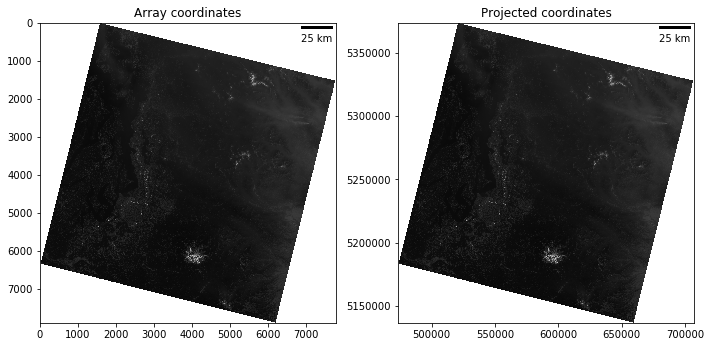

## Now try the convenience plotting `rasterio.plot.show()` function
* Need to pass the original rasterio datasets here, not your array
* https://rasterio.readthedocs.io/en/latest/topics/plotting.html
* This will automatically set the extent of the axes

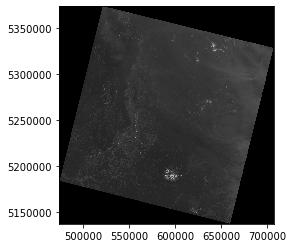

## Extract a 256x256 pixel window around the center pixel of the array
* Use the NumPy slicing/indexing functionality here
    * Maybe a good time to review https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html
* You'll need to define the appropriate slices for both rows and columns
    * Try to define and use variables for window width and height, rather than hardcoding 256 or 128
* Preview the resulting 256x256 pixel array

In [79]:
rw.shape

(256, 256)

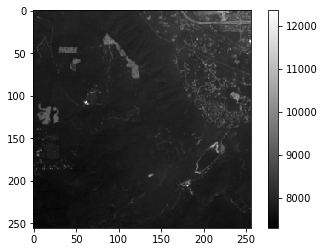

## Write a function to normalize (AKA contrast stretch) the DN values
* The input image pixel values are `UInt16` (unsigned, 16-bit integer, spanning the range 0-65535)
* We want to convert to `float` values over the range (0.0-1.0)
* So we need a function to remap the DN values from 0-65535 to 0-1
    * Simplest approach would be to map 0 -> 0 and 65535 -> 1, so just divide our original values by 65535
    * But we want to improve contrast.  
    * One option is to use the actual min and max values in the array `array.min()` -> 0 and `array.max()` -> 1
        * To do this, we need to account for an offset (`array.min()`) and scaling (`array.max() - array.min()`)
    * However, there could some outlier values (very bright or very dark pixels) that would set our min and max, leaving poor contrast over most valid pixels in the image. So a more robust contrast enhancement is to use the 2-98 percentile DN values as the min and max values
        * The DN value of the 2nd percentile should map to 0
        * The DN value at the 98th percentile should map to 1
        * Note that we will now have some values less than 0 and some values greater than 1 in the output!
        * Optional - "clip" the remapped values, so that any values less than 0 are set to 0, and any values greater than 1 are set to 1
            * See https://docs.scipy.org/doc/numpy/reference/generated/numpy.clip.html
* Your function should return a new `float` array with values distributed over the (0.0-1.0) range
* Think this through, and sanity check your output

In [38]:
#def norm(a, perc_lim=(2, 98), clip=True):

## Contrast stretch your 256x256 px array and run imshow
* Apply your function to the 256x256 px array
* You should see enchanced contrast compared to your earlier plot
* Note: the new array values are from 0-1, so if you did not `clip` values in your function, you will need to specify `vmin=0, vmax=1` in your `imshow` call to see the proper contrast stretch

7514.0 9128.0


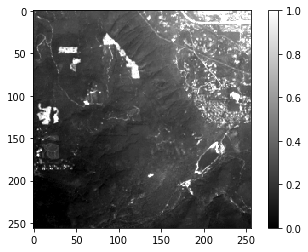

In [78]:
f, ax = plt.subplots()
#ax.imshow(norm(rw), cmap='gray', vmin=0, vmax=1)
im = ax.imshow(norm(rw, clip=True), cmap='gray')
plt.colorbar(im);

## Define a subwindow for subsequent analysis
* Could do the remainder of the analysis with the full images, but faster with a small subset
* Let's define 1024x1024 px windows around Mt. Rainer and Seattle
* Use the `rasterio.windows.Window` functionality for this
    * https://rasterio.readthedocs.io/en/latest/topics/windowed-rw.html
    * Syntax is `rasterio.windows.Window(col_offset, row_offset, width, height)`

In [83]:
import rasterio.windows

#Mt. Rainier
window = rasterio.windows.Window(3600, 5600, 1024, 1024)

#Seattle
#window = rasterio.windows.Window(2100, 2800, 1024, 1024)

In [84]:
#Define the bounds and extent
window_bounds = rasterio.windows.bounds(window, src.transform)
print("Window bounds: ", window_bounds)
extent = [window_bounds[0], window_bounds[2], window_bounds[1], window_bounds[3]]
print("Window extent: ", extent)

Window bounds:  (581385.0, 5174595.0, 612105.0, 5205315.0)
Window extent:  [581385.0, 612105.0, 5174595.0, 5205315.0]


## Define a function to read only this subwindow into an array

In [85]:
def rio2ma(fn, b=1, window=None):
    a = None
    with rio.open(fn) as src:
        #If working with PAN, scale offset and dimensions by factor of 2
        if 'B8' in fn and window is not None:
            window = rasterio.windows.Window(window.col_off*2, window.row_off*2, window.width*2, window.height*2)
        #Read in the window
        a = src.read(b, window=window)
        #Prepare masked array
        a = np.ma.masked_equal(a, 0)
        #Set to float
        #a = a.astype('float')
        #Set nodata to np.nan
        #a[a==0] = np.nan
        return a

# Use this function to load the Panchromatic band
* Store as a new array
* Note that we get a 2048x2048 px array, due to the logic in the function above

In [86]:
p = rio2ma(p_fn, window=window)

In [87]:
p.shape

(2048, 2048)

# Display the Panchromatic band with matplotlib imshow
* https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.imshow.html#matplotlib.axes.Axes.imshow
* Use the 'gray' colormap
* Pass the `extent` to imshow
    * My code above already calculated this for you!
* Add a scalebar

6474.0 24048.0


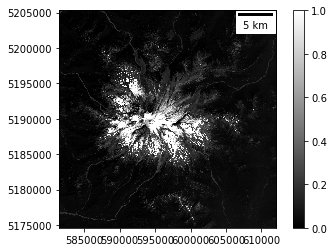

# Create a RGB (red, green, blue) composite
* This represents "true" color
* Use the `rio2ma` function to load a window from the red, green and blue channels as NumPy arrays
    * Don't try to load the full images here!  Can potentially fill RAM on your Jupyterhub server, leading to kernel restart!
* Then normalize each channel independently using your `norm` function
* Use numpy `dstack` to combine as a 3D array
    * Be careful of the band order here!
    * Final array shape should be (1024, 1024, 3)

## Create a plot of the RGB composite
* Pass the 3-band array to `imshow`, define the `extent` and add a scalebar
* Trees should appear dark green, exposed rock: brown, exposed glacier ice: light blue, and snow: white

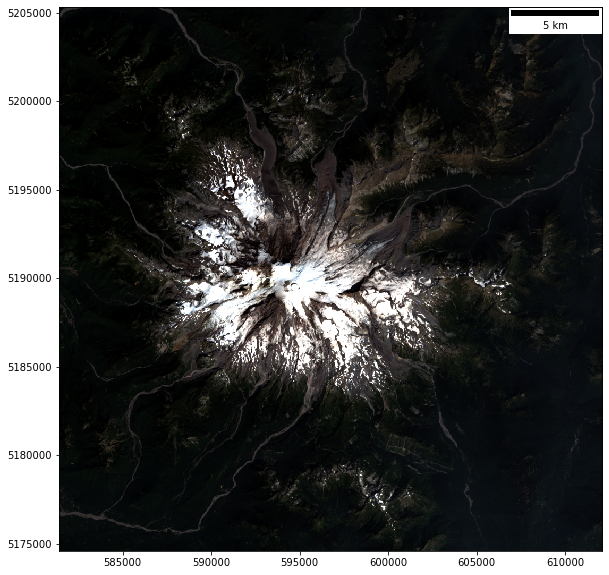

# CIR (color-infrared)
* Create a similar plot for color-infrared image
* Look up the band combination required here and be careful with order
    * Sanity check: vegetation should appear red
        * Deciduous/leafy vefetation will be bright red, while coniferous vegetation will be a darker red

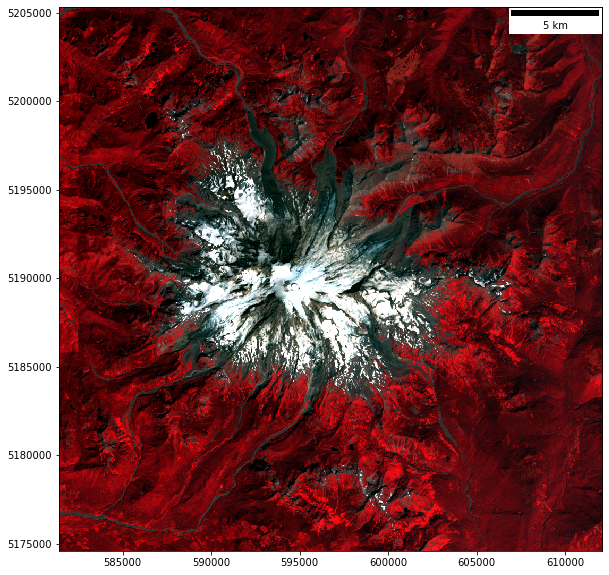

## Create a composite, interactive figure with PAN, RGB, and CIR
* Use the `plt.subplots()` with appropriate number of rows and columns
    * Use the `sharex` and `sharey` options - this will "link" the extent of the three subplots, so if you zoom/pan in one, the others will update to match!
    * Set an appropriate `figsize`
* Pass the projected bounds to the imshow `extent` option
* Use `gray` colormap for the PAN, you shouldn't need to specify a colormap for RGB or CIR
* Add a scalebar to the first plot
* Add appropriate titles to each subplot
* Use `plt.tight_layout()` to clean up axes: https://matplotlib.org/tutorials/intermediate/tight_layout_guide.html

6474.0 24048.0


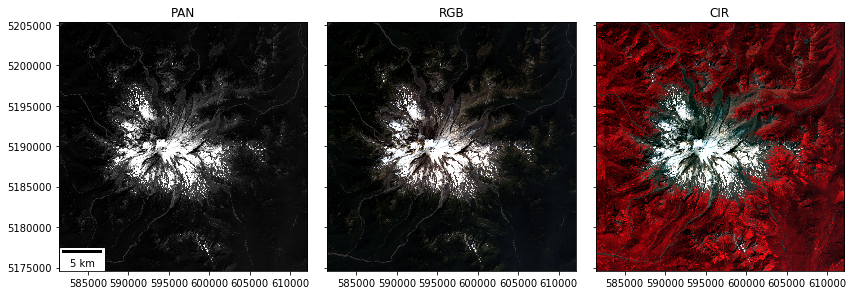

## Interactive Analysis
* Ensure that you are using `%matplotlib widget` backend and rerun the above cell to create an interactive version of the PAN/RGB/CIR plot
* Zoom all the way in until you see individual pixels
    * Note the difference in resolution between the PAN and RGB/CIR images
    * Note how the scalebar updates (sanity check your pixel sizes here of 15 m and 30 m, if incorrect, probably an issue with your `ScaleBar` or `extent`)
* Note the changing values for (x,y) coordinates and the DN value(s) in the lower right corner of your plot
    * Should be 1 value for PAN, 3 values for RGB and CIR
    * All values should be in the range of 0-1, because you already normalized each channel
* Experiment with some different interpolation methods for `imshow` display: https://matplotlib.org/gallery/images_contours_and_fields/interpolation_methods.html
    * At least try `'none'`, `'bilinear'`, `'bicubic'`

In [92]:
#%matplotlib widget

## Extra Credit: Create a plot comparing different interpolation methods for the same features
* Can zoom in on Paradise to see roads, buildings, cars/RVs: https://goo.gl/maps/YaUWLTXZBf7vTukYA
* Note how interpolation method affects your ability to resolve features in the images 

In [99]:
#Paradise area with roads, parking lots, buildings
subwindow = rgb[700:800,450:550]
subwindow = p[1525:1625,925:1025]

6631.0 10570.055000000011
6631.0 10570.055000000011
6631.0 10570.055000000011
6631.0 10570.055000000011
6631.0 10570.055000000011
6631.0 10570.055000000011
6631.0 10570.055000000011
6631.0 10570.055000000011


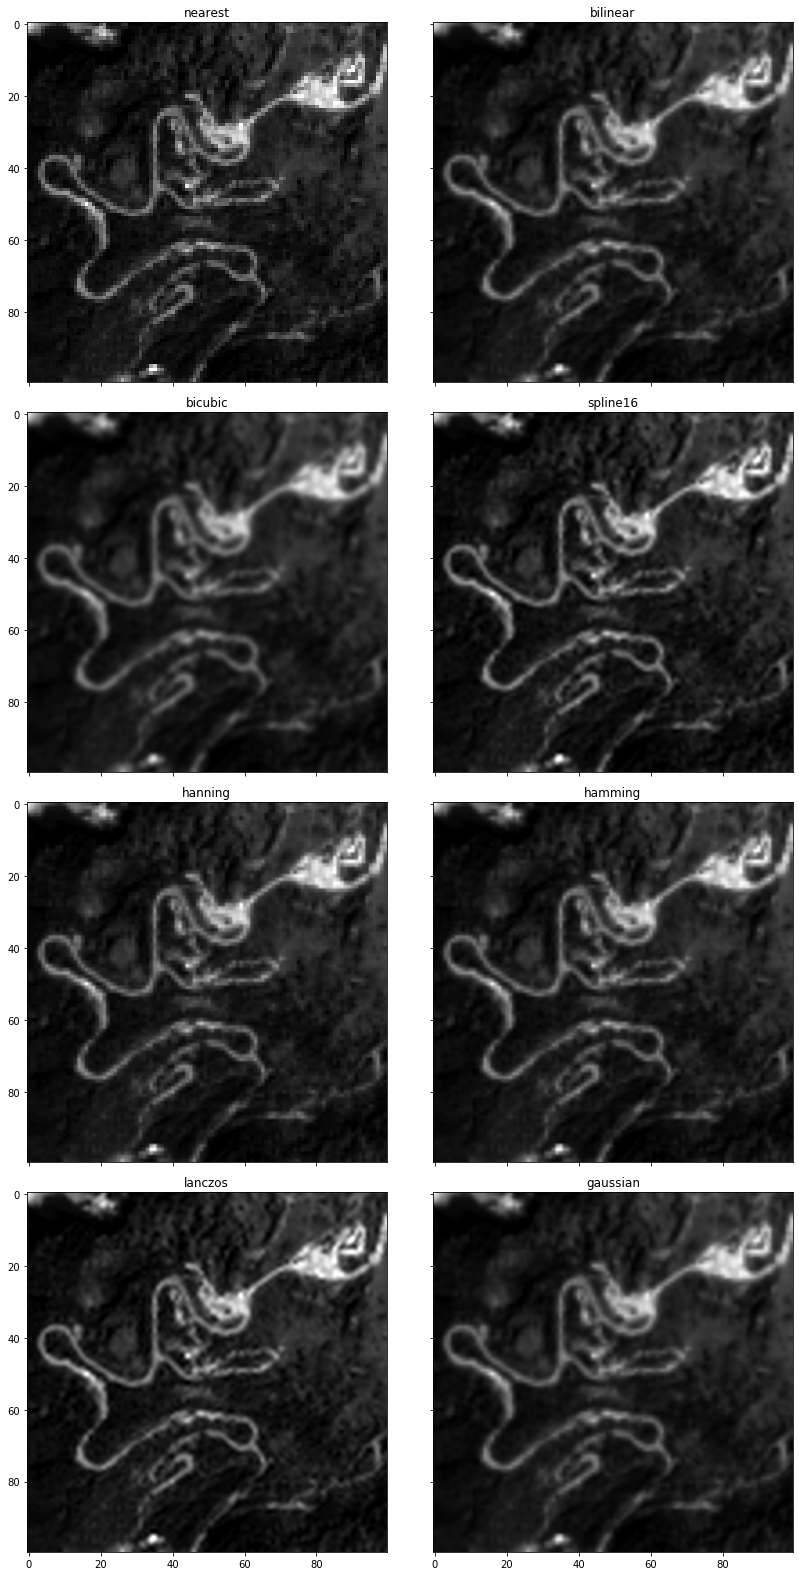

# Raster band math and index ratios
* Let's use some common band ratios to classify vegetation, snow and water
* NOTE: if you're using `UInt16` masked arrays here, you will want to convert each to `float`, as some addition/subtraction operations could result in values outside of 0-65536 (e.g., areas that are bright in all visible bands, like snow).
    * Can use `myarray.astype(float)` for this
    * If you don't do this, you will end up with "wrapping" artifacts

In [ ]:
#These should already be loaded
nir = nir.astype(float)
r = r.astype(float)
g = g.astype(float)

In [101]:
#Load and convert the swir channel as well
swir = rio2ma(swir_fn, window=window)
swir = swir.astype(float)

## Compute NDVI (normalized difference vegetation index)
* Resources:
    * https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index
    * https://eos.com/ndvi/
* Create a new array to store NDVI from the bands you've already loaded
* This should be a simple one-liner, basic raster band math
    * Compute the ratio using the original band values (not normalized values)
* Plot and inspect
    * Plot original ndvi
    * Plot contrast-stretched ndvi using your normalization function above
    * Do you see different NDVI values for dense conifer trees (most of the scene) vs. open meadows or recently logged plots dominated by grass and other deciduous plants?

-0.05212441538791986 0.4664155743355847


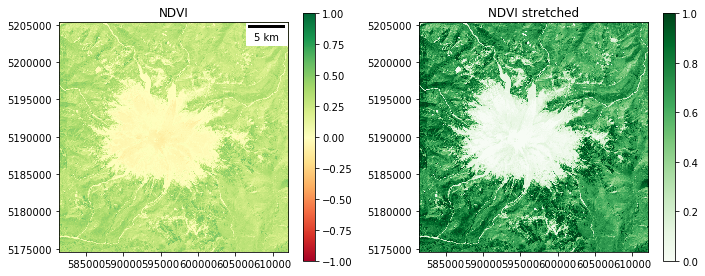

## NDSI (normalized difference snow index)
* There are multiple definitions of NDSI in the literature, but let's use this one (using SWIR, since we have it available with LS-8):
    * https://eos.com/ndsi/

-0.23621667504351607 0.6027555934396958


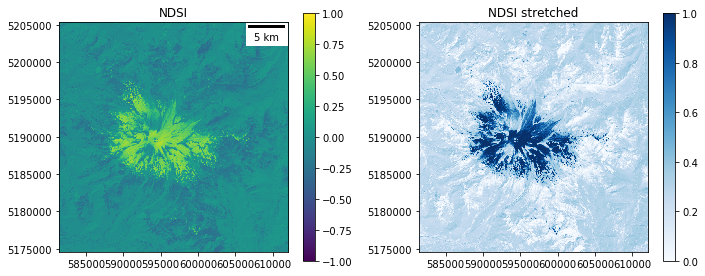

## NDWI (normalized difference water index)
* Again, multiple definitions for different sensors.  Let's use the formula for surface water bodies here:
    * https://en.wikipedia.org/wiki/Normalized_difference_water_index


-0.41129885318841813 0.04021959494130882


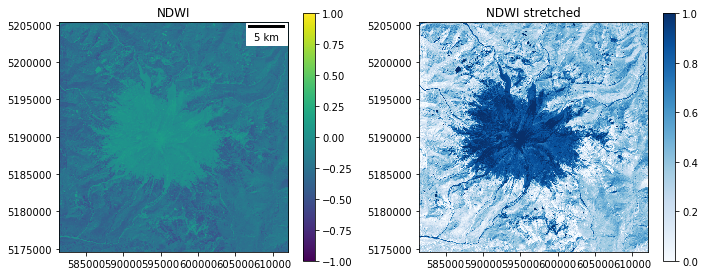

## Create a composite, interactive figure with linked RGB, CIR, NDVI, NDSI, and NDWI products
* Use the pan/zoom functionality of `%matplotlib widget` to explore the scene a bit
    * Zoom in on some vegetation, snow near the summit, and surface water like Mowich Lake (https://goo.gl/maps/V6YFJQPcfrDi9UXH6)
* Note how the different indices change (see interactive values for cursor position on each subplot), which should hopefully provide better sense of what the different indices are showing

-0.05212441538791986 0.4664155743355847
-0.23621667504351607 0.6027555934396958
-0.41129885318841813 0.04021959494130882


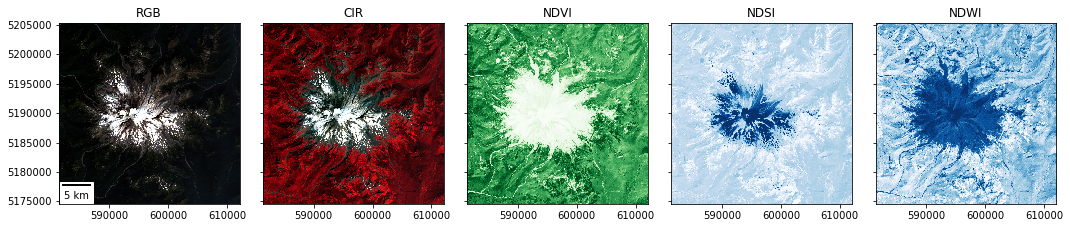

## Create a binary vegetation mask
* Use some simple thresholding to create a vegetation mask from NDVI
    * This might be a useful resource: https://eos.com/ndvi/
* Probably useful to plot a histogram of NDVI values, and to use with your map to define a threshold
* Output mask should be boolean (True/False)
    * Should be true (1) for vegetation pixels and false (0) for all other pixels
* Create a figure with two subplots to show the NDVI map and your corresponding vegetation mask

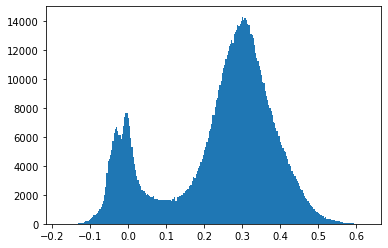

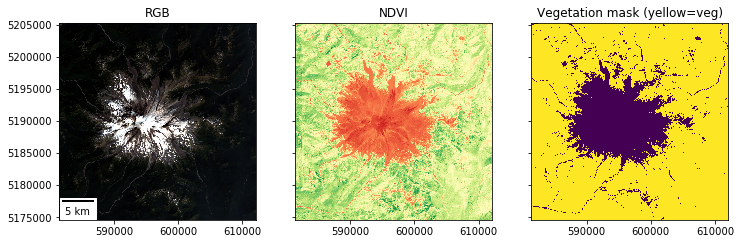

## Create a binary snow mask
* Follow a similar procedure with thresholding to create a snow mask from NDSI
* Plot a histogram and experiment with your own values until you find a threshold that looks good based on snow extent observed in RGB image

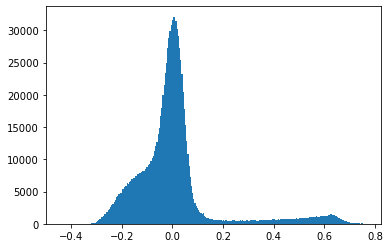

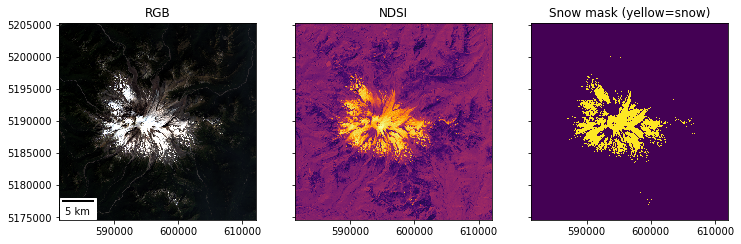

In [114]:
f, axa = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12,5))
axa[0].imshow(rgb, extent=extent)
axa[0].set_title('RGB')
axa[0].add_artist(ScaleBar(1.0, location='lower left'))
axa[1].imshow(ndsi, cmap='inferno', extent=extent)
axa[1].set_title('NDSI')
axa[2].imshow(snow_mask, extent=extent)
axa[2].set_title('Snow mask (yellow=snow)');

## Now, use your snow mask to estimate the area (km<sup>2</sup>) covered by snow
* You will need to count the number of True (1) values in your boolean snow mask
* Remember, that you have a regular grid here, so you know the dimensions of each grid cell in meters, and can determine the area covered by that pixel in square meters
* *Note: Based on what we learned in our earlier lab on CRS/projections, this calculation should really be done using an equal-area projection, but fine to estimate with default UTM projection*
* Sanity check: make sure your estimate is consistent with expected dimensions for Mt. Rainier and your LS-8 image.
* Hint: Something between ~60-70 km^2 seems reasonable

# Extra Credit
1. Repeat some of the above analysis for Seattle. You’ll need to define an appropriate window to extract. Zoom in on UW campus - can you identify familiar landmarks?  Can you find your neighborhood park?
2. Repeat the above Mt. Rainier analysis for the 20181228 and 20180818 images (or other cloud-free imagery). Create difference maps and do some basic quantitative/qualitative analysis of how NDVI and snow-covered area changed between the summer and winter images.